In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import add

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Read Captions File

In [32]:
# Reading the Description file

with open("/content/drive/MyDrive/AML/Flickr8k_text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [33]:
captions = captions.split("\n")[:-1]

In [34]:
len(captions)

40460

In [35]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]

    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [36]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

In [37]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """

def clean_text(sample):
    sample = sample.lower()

    sample = re.sub("[^a-z]+"," ",sample)

    sample = sample.split()

    sample = [s for s in sample if len(s)>1]

    sample = " ".join(sample)

    return sample

In [38]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [39]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [40]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [41]:
# writing clean description to .txt file

f = open("/content/drive/MyDrive/AML/descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [4]:
#  reading description file

f = open("/content/drive/MyDrive/AML/descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [16]:
# finding the unique vocabulary

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [17]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [18]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [19]:
len(all_vocab)

1845

# Loading Training Testing Data

In [25]:
# TrainImagesFile
f = open("/content/drive/MyDrive/AML/Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [26]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [27]:
# TestImagesFile
f = open("/content/drive/MyDrive/AML/Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [28]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [29]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [52]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Data Preprocessing - Images

In [ ]:
"""
In this section, we will load our images and do some processing so that we can feed it in our network.
"""

In [5]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102967424/102967424 [==============================] - 1s 0us/step


In [6]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [7]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [43]:
images = "/content/drive/MyDrive/AML/Flickr8k_Dataset"

In [46]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [47]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [32]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):

    img = "/content/drive/MyDrive/AML/Flickr8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+ str(ix))

print("Time taken in seconds =", time()-start)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Encoding image- 1100
1/1 [==============================] - 0s 24ms/step
Encoding image- 1200
1/1 [==============================] - 0s 22ms/step
Encoding image- 1300
1/1 [==============================] - 0s 34ms/step
Encoding image- 1400
1/1 [==============================] - 0s 24ms/step
Encoding image- 1500
1/1 [==============================] - 0s 22ms/step
Encoding image- 1600
1/1 [==============================] - 0s 29ms/step
Encoding image- 1700
1/1 [==============================] - 0s 37ms/step
Encoding image- 1800
1/1 [==============================] - 0s 23ms/step
Encoding image- 1900
1/1 [==============================] - 0s 33ms/step
Encoding image- 2000
1/1 [==============================] - 0s 22ms/step
Encoding image- 2100
1/1 [==============================] - 0s 22ms/step
Encoding image- 2200
1/1 [==============================] - 0s 36ms/step
Encoding image- 2300


In [33]:
# Save the bottleneck train features to disk

with open("/content/drive/MyDrive/AML/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [59]:
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "/content/drive/MyDrive/AML/Flickr8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+ str(ix))

print("Time taken in seconds =", time()-start)

1/1 [==============================] - 9s 9s/step
Encoding image- 0
1/1 [==============================] - 0s 25ms/step
Encoding image- 100
1/1 [==============================] - 0s 23ms/step
Encoding image- 200
1/1 [==============================] - 0s 23ms/step
Encoding image- 300
1/1 [==============================] - 0s 38ms/step
Encoding image- 400
1/1 [==============================] - 0s 37ms/step
Encoding image- 500
1/1 [==============================] - 0s 35ms/step
Encoding image- 600
1/1 [==============================] - 0s 27ms/step
Encoding image- 700
1/1 [==============================] - 0s 24ms/step
Encoding image- 800
1/1 [==============================] - 0s 23ms/step
Encoding image- 900
1/1 [==============================] - 0s 27ms/step
Time taken in seconds = 414.6574146747589


In [60]:
# Save the bottleneck train features to disk

with open("/content/drive/MyDrive/AML/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [8]:
# Load the train images features from disk

with open("/content/drive/MyDrive/AML/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [9]:
# Load the test images features from disk

with open("/content/drive/MyDrive/AML/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [64]:
encoding_test

{'/3385593926_d3e9c21170.jpg': array([0.33316958, 0.3834775 , 0.07253429, ..., 0.90832055, 0.35600442,
        1.0914084 ], dtype=float32),
 '/2677656448_6b7e7702af.jpg': array([0.29456076, 0.09500395, 0.7013545 , ..., 0.01996778, 0.29111898,
        0.10959309], dtype=float32),
 '/311146855_0b65fdb169.jpg': array([0.01133571, 0.08780418, 0.14325388, ..., 0.03005839, 1.185714  ,
        0.06954551], dtype=float32),
 '/1258913059_07c613f7ff.jpg': array([0.04770479, 1.4354494 , 0.10770185, ..., 0.13344467, 0.11505588,
        2.049625  ], dtype=float32),
 '/241347760_d44c8d3a01.jpg': array([0.06552858, 6.6828284 , 0.3176344 , ..., 0.06200404, 0.0374287 ,
        0.04522508], dtype=float32),
 '/2654514044_a70a6e2c21.jpg': array([1.9562054 , 0.04316795, 0.11143783, ..., 0.02008322, 0.6832557 ,
        0.43294072], dtype=float32),
 '/2339106348_2df90aa6a9.jpg': array([0.08876384, 1.1927905 , 0.07676496, ..., 0.01899938, 0.13417603,
        0.13799444], dtype=float32),
 '/256085101_2c2617c5d

# Data Preprocessing - Captions

In [20]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [21]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [22]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well.

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [33]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


# Data Preparation using Generator Function

In [10]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:

        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train["/"+key+".jpg"]

            for desc in desc_list:

                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

# Word Embedding

In [11]:
f = open("/content/drive/MyDrive/AML/glove.6B.50d.txt", encoding='utf8')

In [13]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")

    embedding_index[word] = coefs

f.close()

## Converting words into vectors  Directly - (Embedding Layer Output)

In [30]:
def get_embedding_output():

    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))

    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector

    return embedding_output


embedding_output = get_embedding_output()

In [31]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [12]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [34]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [35]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [37]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [38]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Train Our Model

In [39]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [54]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/AML/model_weights/model_' + str(i) + '.h5')

<ipython-input-54-24cc8210fa6f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 44s 18ms/step - loss: 4.3192


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 35s 18ms/step - loss: 2.7803


In [40]:
model = load_model("/content/drive/MyDrive/AML/model_weights/model_9.h5")

# Predictions

In [41]:
def predict_caption(photo):
    in_text = "startseq"

    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word

        if word =='endseq':
            break


    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption

In [44]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)

Output hidden; open in https://colab.research.google.com to view.

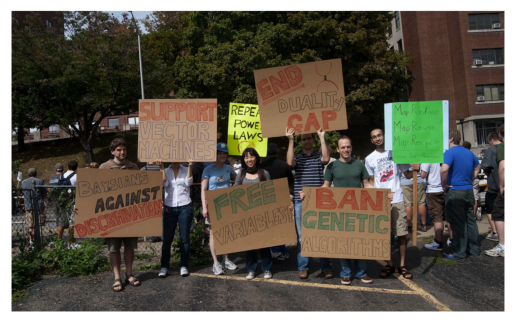

1/1 [==============================] - 0s 25ms/step
group of people are sitting on bench and one is standing on the phone


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model

# Load your trained model
img = "/content/drive/MyDrive/AML/Test images/SVM.png"
i = plt.imread(img)
plt.imshow(i)
plt.axis("off")
plt.show()

# Load the image
img = "/content/drive/MyDrive/AML/Test images/SVM.png"  # Replace with the path to your custom photo
img = encode_image(img)
img = img.reshape((1,2048))

caption = predict_caption(img)

# Print the generated caption
print(caption)


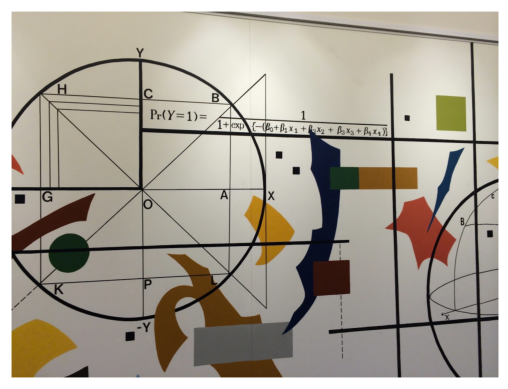

1/1 [==============================] - 0s 25ms/step
two men are sitting on the ground and playing hockey


In [49]:
# Load your trained model
img = "/content/drive/MyDrive/AML/Test images/SAS.png"
i = plt.imread(img)
plt.imshow(i)
plt.axis("off")
plt.show()

# Load the image
img = "/content/drive/MyDrive/AML/Test images/SAS.png"  # Replace with the path to your custom photo
img = encode_image(img)
img = img.reshape((1,2048))

caption = predict_caption(img)

# Print the generated caption
print(caption)
